### Use and train a Data Reuploading model

In this tutorial we show how to setup and train a quantum machine learning model implementing a Data Reuploading strategy.
We will make use of our interface to structure a quantum circuit which is composed of an alternating execution of trainable and encoding layers.

In fact, the main idea behind data reuploading strategies is that data are encoded more than once into our quantum machine learning model. This approach usually leads to a quantum circuit which is approximating a target in a way which is equivalent to a Fourier approximation. In particular, the number of times the data are uploaded is proportional to the number of frequencies populating the Fourier spectrum and the parametrized part of the circuit is responsible of the tuning of the coefficients of this same Fourier series. For more details, a good reference is [Schuld M., Sweke R., Meyer J. - 2021](https://arxiv.org/abs/2008.08605).

<img src="./figures/reuploading.svg" width="600" height="200" alt="My Image">

### Some imports

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn

from qibo import Circuit, gates, construct_backend

from qiboml.models.encoding import PhaseEncoding
from qiboml.models.decoding import Expectation
from qiboml.interfaces.pytorch import QuantumModel
from qiboml.operations.differentiation import PSR

### The target function to be fitted

To the purpose of this introductory example, we are going to fit a one-dimensional function.

In [3]:
# Prepare the training dataset 
def f(x):
    return 1 * torch.sin(x)  ** 2 - 0.3 * torch.cos(x) 

num_samples = 30
x_train = torch.linspace(0, 2 * np.pi, num_samples, dtype=torch.float64).unsqueeze(1)
y_train = f(x_train)

# Normalizing it to be between -1 and 1 (because we are going to use a Z observable in our decoding)
y_train = 2 * ( (y_train - min(y_train)) / (max(y_train) - min(y_train)) - 0.5 )

In [4]:
# A plotting function which will be useful now and later
def plot_target(x, target, predictions=None):
    """Plot target function and, optionally, the predictions of our model."""
    plt.figure(figsize=(4, 4 * 6 / 8), dpi=120)
    plt.plot(
        x_train, 
        y_train,
        marker=".",
        markersize=10,
        color="blue", 
        label="Targets",
        alpha=0.7
    )
    if predictions is not None:
        plt.plot(
            x_train, 
            y_pred.detach().numpy(), 
            marker=".",
            markersize=10,
            color="red", 
            label="Predictions",
            alpha=0.7
        )
    plt.xlabel(r"$x$")
    plt.ylabel(r"$f(x)$")
    plt.legend()
    plt.show()

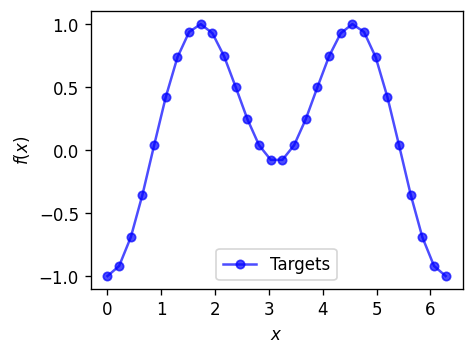

In [5]:
# Plotting
plot_target(x=x_train, target=y_train)

### The circuit's building blocks

We now need too construct the circuit's building blocks (encoding layers, trainable layers and decoding).
We are going to perform the fit of a one dimensional function and, to do so, we don't need more than one qubit.

We can start from the encoding layer, where we decide to encode the data into a single qubit rotation around the $x$ axis.

In [6]:
# Setting the number of qubits
nqubits = 1

# Encoding layer
encoding_circ = PhaseEncoding(
    nqubits=nqubits, 
    encoding_gate=gates.RX
)

Then, we need to define a trainable layer. 

We write a general function here below, which can enable more than one qubit circuits and where one can freely decide if to introduce some entanglement. In particular, we set the entangling gate to be controlled rotations around the $x$ axis. This is allowing the model to train itself to "switch off" the entanglement in case it is not needed (it will train the angle of the controlled rotations to be closer to zero).

In [7]:
# Trainable layer
def trainable_circuit(entanglement=True):
    """
    Construct a trainable quantum circuit where the amoung of entanglement can be tuned 
    if the argument `entanglement` is set equal to `True`."""
    trainable_circ  = Circuit(nqubits)
    for q in range(nqubits):
        trainable_circ.add(gates.RY(q=q, theta=np.random.randn()))
        trainable_circ.add(gates.RZ(q=q, theta=np.random.randn()))
    if nqubits > 1 and entanglement:
        [trainable_circ.add(gates.CRX(q%nqubits, (q+1)%nqubits, theta=np.random.randn()) for q in range(nqubits))]
    return trainable_circ

#### Building a layered circuit structure

We combine now together multiple encoding layers alternated to some trainable layers. We need to ensure the instances of the trainable layers are different, or Pytorch will train all the layers as they are different repetitions of the same object (with the same parameters).

In [8]:
# We set a number of layers
nlayers = 5

# We initialise an empty circuit structure
circuit_structure = []
# We populate it with alternation of encoding (always the same) and trainable layers (always a new instance)
for _ in range(nlayers):
    circuit_structure.extend([encoding_circ, trainable_circuit(entanglement=False)])

#### Defining the decoding strategy and building the model

Then, we need to define a decoding strategy. It is common to compute expectation values and this is what we are going to do here. In particular, we will compute the expectation value of a non interacting Z hamiltonian, as it is set as default in our interface. 

In [9]:
# Decoding layer
decoding_circ = Expectation(
    nqubits=nqubits, 
    backend=construct_backend("numpy")
)

Since we already used the native Pytorch differentiation in previous examples, we decide here to train our model computing gradients using a method which is hardware-compatible. With "hardware-compatible" we mean that it can be executed also on a real quantum device, where the results are usually affected by statistical uncertainties due to the necessity of measuring many times the final state. In fact, measures make the final state collapse in one of its components with a probability which can be computed as the squared modulus of the correspondent amplitude in the statevector. 

The method typically used to compute gradients in a shot-noisy scenario is called _parameter-shift rule_, and it was introduced in [Schuld M et al. - 2018](https://arxiv.org/abs/1811.11184). In Qiboml, this differentiation technique is implemented in `qiboml.operations.differentiation.PSR` and we will pass it as an argument of our quantum model.

---

Finally, we can assemble the whole quantum model.

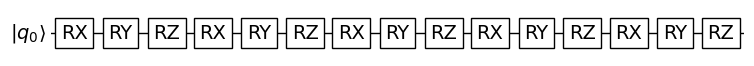

In [10]:
# The whole model
model = QuantumModel(
    circuit_structure=circuit_structure,
    decoding=decoding_circ,
    differentiation=PSR(),    
)

# Let's draw it
fig = model.draw()

### Using Pytorch to fit!

Now, we can setup a classical Pytorch training loop to find an optimal quantum circuit for fitting our target function. 

We start by selecting proper optimizer and cost function:

In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

And we then perform a classical training loop.

In [12]:
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    # Use torch.stack to get a tensor of shape (100, 1, 1)
    y_pred = torch.stack([model(x) for x in x_train])
    # Remove the extra singleton dimension so that y_pred has shape (100, 1)
    y_pred = y_pred.squeeze(-1)
    
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

Epoch 0: Loss = 0.7088171685054033
Epoch 10: Loss = 0.17060043188191035
Epoch 20: Loss = 0.055720545209859626
Epoch 30: Loss = 0.03157628705875708
Epoch 40: Loss = 0.02357713843653329
Epoch 50: Loss = 0.014597760300648984
Epoch 60: Loss = 0.008907009460788502
Epoch 70: Loss = 0.004529348559555209
Epoch 80: Loss = 0.0023417383057926706
Epoch 90: Loss = 0.0014750797011756902


### A final look to our results

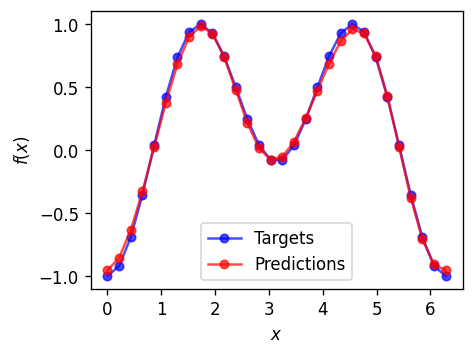

In [13]:
plot_target(x=x_train, target=y_train, predictions=y_pred)

We fitted it 🥳